# Regression Analysis:
A. Predict the price of the Uber ride from a given pickup point to the agreed drop-off
location. Perform following tasks:
1. Pre-process the dataset.
2. Identify outliers.
3. Check the correlation.
4. Implement linear regression and ridge, Lasso regression models.
5. Evaluate the models and compare their respective scores like R2, RMSE, etc.

Dataset link: https://www.kaggle.com/datasets/yasserh/uber-fares-dataset

In [ ]:
#import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as lr, Ridge as rd, Lasso as lo
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

In [ ]:
uber = pd.read_csv("/content/uber.csv")
print(f"Head : \n{uber.head(5)}\n")
print(f"Uber shape: {uber.shape} \n")
print(uber.info(verbose=True))
print(f"Uber sample : \n{uber.sample(5)}\n")

Head : 
   Unnamed: 0                            key  fare_amount  \
0    24238194    2015-05-07 19:52:06.0000003          7.5   
1    27835199    2009-07-17 20:04:56.0000002          7.7   
2    44984355   2009-08-24 21:45:00.00000061         12.9   
3    25894730    2009-06-26 08:22:21.0000001          5.3   
4    17610152  2014-08-28 17:47:00.000000188         16.0   

           pickup_datetime  pickup_longitude  pickup_latitude  \
0  2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1  2009-07-17 20:04:56 UTC        -73.994355        40.728225   
2  2009-08-24 21:45:00 UTC        -74.005043        40.740770   
3  2009-06-26 08:22:21 UTC        -73.976124        40.790844   
4  2014-08-28 17:47:00 UTC        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.999512         40.723217                1  
1         -73.994710         40.750325                1  
2         -73.962565         40.772647                1  
3 

**Observation**

- Column unnamed maybe indicates unique order number which is of no use
- column pickup_datetime also is of no use
- *fare_amount* is *target* variable
- Coordinated appear to be of New York City
- In order to get a better relationship of amount with coordinates, they can be converted into distances
- Having known that NYC follows grid like roads so Manhattan Distance is most suitable option to calculate distance from coordinates
- The "key" column also seems unnecessary, however can have some relation or nuance of dependency on amount if factors like weekdays vs weeneds affect. Let's check this

In [ ]:
#preprocess the dataset

uber.drop(columns=["Unnamed: 0","pickup_datetime"], inplace=True)
print(uber.isnull().sum()*100/len(uber))
uber.dropna(axis=0, inplace=True)

key                  0.0000
fare_amount          0.0000
pickup_longitude     0.0000
pickup_latitude      0.0000
dropoff_longitude    0.0005
dropoff_latitude     0.0005
passenger_count      0.0000
dtype: float64


1 dropoff coordinate is missing as seen in uber.info(), it accounts only for 0.0005% of data. Handled by dropping it.

In [ ]:
uber.duplicated().sum()

0

In [ ]:
uber.isnull().sum()

key                  0
fare_amount          0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [ ]:
uber.shape

(199999, 7)

**Extracting Weekday from key column**

In [ ]:
uber["key"]=pd.to_datetime(uber["key"])
uber["weekday"]=uber["key"].dt.weekday
uber["day"]=uber["key"].dt.day
uber["month"]=uber["key"].dt.month
uber["year"]=uber["key"].dt.year
uber["hour"]=uber["key"].dt.hour

In [ ]:
temp={"key","weekday","day","month","year","hour"}
for t in temp:
  print(t,"\n")
  print(f"{uber[t].sample(5)}\n")


year 

108438    2012
145470    2014
125458    2013
96657     2009
86103     2009
Name: year, dtype: int32

key 

15513    2012-11-19 07:17:36.000000300
186896   2015-04-16 07:27:28.000000100
97941    2013-04-09 19:39:08.000000400
150737   2010-02-09 23:03:59.000000300
65204    2013-01-09 21:37:40.000000200
Name: key, dtype: datetime64[ns]

hour 

8232      13
197714    22
51227     19
39101     13
42726      6
Name: hour, dtype: int32

month 

75178      3
148584     2
113579     9
168173    12
90308      2
Name: month, dtype: int32

day 

123496    17
131888    19
76355     10
83659     28
116394     5
Name: day, dtype: int32

weekday 

34877     2
64714     2
68527     3
122389    2
194749    1
Name: weekday, dtype: int32



Here we made weekdays as a categorical variable from 0 to 6

Month from 0 to 11

Year in yyyy format

Hour from 0 to 23

day from 1 to 30/31

**computing distance in km from the coordinates**

In [ ]:
'''lat_km = 111 #km per degree of latitude
long_km = 85 #km per degree of latitude'''

'lat_km = 111 #km per degree of latitude\nlong_km = 85 #km per degree of latitude'

In [ ]:
'''uber['manhattan']=((uber['pickup_latitude']-uber['dropoff_latitude']).abs()* lat_km +
(uber['pickup_longitude']-uber['dropoff_longitude']).abs()* long_km)'''

"uber['manhattan']=((uber['pickup_latitude']-uber['dropoff_latitude']).abs()* lat_km +\n(uber['pickup_longitude']-uber['dropoff_longitude']).abs()* long_km)"

In [ ]:
!pip install geopy
from geopy.distance import great_circle

In [ ]:
def filter_latitude(val):
    return val if -90 <= val <= 90 else np.nan
def filter_longitude(val):
    return val if -180 <= val <= 180 else np.nan


In [ ]:
uber['pickup_longitude']=uber['pickup_longitude'].apply(filter_longitude)
uber['dropoff_longitude']=uber['dropoff_longitude'].apply(filter_longitude)
uber['pickup_latitude']=uber['pickup_latitude'].apply(filter_latitude)
uber['dropoff_latitude']=uber['dropoff_latitude'].apply(filter_latitude)

In [ ]:
uber.isnull().sum()

key                  0
fare_amount          0
pickup_longitude     7
pickup_latitude      4
dropoff_longitude    3
dropoff_latitude     3
passenger_count      0
weekday              0
day                  0
month                0
year                 0
hour                 0
dtype: int64

In [ ]:
uber.dropna(inplace=True)

In [ ]:
uber.head()

key  fare_amount  pickup_longitude  \
0 2015-05-07 19:52:06.000000300          7.5        -73.999817   
1 2009-07-17 20:04:56.000000200          7.7        -73.994355   
2 2009-08-24 21:45:00.000000610         12.9        -74.005043   
3 2009-06-26 08:22:21.000000100          5.3        -73.976124   
4 2014-08-28 17:47:00.000000188         16.0        -73.925023   

   pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  \
0        40.738354         -73.999512         40.723217                1   
1        40.728225         -73.994710         40.750325                1   
2        40.740770         -73.962565         40.772647                1   
3        40.790844         -73.965316         40.803349                3   
4        40.744085         -73.973082         40.761247                5   

   weekday  day  month  year  hour  
0        3    7      5  2015    19  
1        4   17      7  2009    20  
2        0   24      8  2009    21  
3        4   26      6  2009     8  
4        3   28      8  2014    17

Here the distance between the pickup and dropoff points in your Uber dataset by using the `great_circle` function from the `geopy` library. This method is based on spherical geometry and is generally more accurate than simply using approximate distance conversions, as it accounts for the Earth’s curvature. Here’s a step-by-step breakdown of how this method works:

### Steps to Implement Method 2

1. **Import Necessary Libraries**  
   The `geopy` library’s `great_circle` function calculates the great-circle distance between two latitude-longitude points on the Earth’s surface. First, import this library and any other required libraries, like `pandas` and `numpy` if they’re not already in use.

   ```python
   from geopy.distance import great_circle
   import numpy as np
   import pandas as pd
   ```

2. **Filter Out Invalid Latitude and Longitude Values**
   Latitude and longitude values should be within specific ranges:
   - Latitude: between -90 and 90 degrees.
   - Longitude: between -180 and 180 degrees.
   
   Define helper functions to filter out any values that fall outside these bounds. Replace invalid values with `NaN` so they can be removed later.

   ```python
   def filter_latitude(val):
       return val if -90 <= val <= 90 else np.nan

   def filter_longitude(val):
       return val if -180 <= val <= 180 else np.nan
   ```

3. **Apply Filters to the Dataset**
   Apply these functions to the latitude and longitude columns for both pickup and dropoff points in your DataFrame to ensure that all values are within valid ranges.

   ```python
   df['pickup_longitude'] = df['pickup_longitude'].apply(filter_longitude)
   df['pickup_latitude'] = df['pickup_latitude'].apply(filter_latitude)
   df['dropoff_longitude'] = df['dropoff_longitude'].apply(filter_longitude)
   df['dropoff_latitude'] = df['dropoff_latitude'].apply(filter_latitude)
   ```

4. **Remove Rows with Missing Values**
   Since invalid coordinates were replaced with `NaN`, these rows can now be removed to prevent errors during distance calculation.

   ```python
   df.dropna(inplace=True)
   ```

5. **Define the Distance Calculation Function**
   Create a function that uses `great_circle` to calculate the distance (in kilometers) between each row’s pickup and dropoff points. The function takes a row of the DataFrame as input, extracts the pickup and dropoff coordinates, and calculates the distance.

   ```python
   def distance_km(row):
       pickup = (row['pickup_latitude'], row['pickup_longitude'])
       dropoff = (row['dropoff_latitude'], row['dropoff_longitude'])
       return great_circle(pickup, dropoff).km
   ```

6. **Apply the Distance Function to the DataFrame**
   Use the `apply` method to apply the `distance_km` function to each row in the DataFrame. Store the results in a new column called `distance_km`.

   ```python
   df['distance_km'] = df.apply(lambda row: distance_km(row), axis=1)
   ```

### How the `great_circle` Calculation Works
The `great_circle` function uses the **Haversine formula**, which calculates the shortest distance over the Earth's surface between two points, assuming the Earth as a sphere. This is generally more accurate than simple approximations for distances across large geographic areas or when precise calculations are necessary.

### Summary of Advantages
- **Accuracy**: Great-circle distances are more accurate for calculating real-world distances, especially across significant distances.
- **Spherical Geometry**: Accounts for the Earth’s curvature, which is important for NYC rides that may span several kilometers.

### Considerations
The `geopy` method is more computationally intensive than a simple degree conversion but is recommended when accurate distance calculations are important, such as in fare estimations or analysis involving geographical patterns.

In [ ]:
from geopy.distance import great_circle
def distancekm(x):
  pickup=(x['pickup_latitude'],x['pickup_longitude'])
  dropoff=(x['dropoff_latitude'],x['dropoff_longitude'])
  return great_circle(pickup,dropoff).km
uber['distance_km']=uber.apply(lambda x: distancekm(x), axis=1)

In your example, lambda is not needed when applying the `filter_longitude` and `filter_latitude` functions because these functions only take a single input (each individual value in the series, like a single latitude or longitude) and return a single output (the cleaned value).

Here’s a breakdown of why lambda is used in one case but not the other:

### Case 1: `apply` Without Lambda

```python
uber['pickup_longitude'] = uber['pickup_longitude'].apply(filter_longitude)
uber['dropoff_longitude'] = uber['dropoff_longitude'].apply(filter_longitude)
uber['pickup_latitude'] = uber['pickup_latitude'].apply(filter_latitude)
uber['dropoff_latitude'] = uber['dropoff_latitude'].apply(filter_latitude)
```

- `filter_longitude` and `filter_latitude` functions are directly applied to each element in the series (`pickup_longitude`, `dropoff_longitude`, etc.).
- `apply` here passes each value in the column (e.g., each individual latitude or longitude) directly to `filter_longitude` or `filter_latitude`.
- Since these functions already take in a single value and return a single value, there’s no need for an additional lambda wrapper.

### Case 2: `apply` with Lambda

```python
uber['distance_km'] = uber.apply(lambda x: distance_km(x), axis=1)
```

- In this case, the `distance_km` function requires a whole row (not just a single column value) to calculate the distance between two points.
- `apply` with `axis=1` passes each row as a Series (referred to as `x` in this case) to the function.
- The lambda function (`lambda x: distance_km(x)`) is used to wrap the function so it can handle a row at a time, passing the entire row `x` to `distance_km`.

In summary:
- **Without lambda**: Use when applying a function that operates on individual column values.
- **With lambda**: Use when applying a function that operates on an entire row or when additional arguments or transformations are required.

In [ ]:
uber.head(5)

key  fare_amount  pickup_longitude  \
0 2015-05-07 19:52:06.000000300          7.5        -73.999817   
1 2009-07-17 20:04:56.000000200          7.7        -73.994355   
2 2009-08-24 21:45:00.000000610         12.9        -74.005043   
3 2009-06-26 08:22:21.000000100          5.3        -73.976124   
4 2014-08-28 17:47:00.000000188         16.0        -73.925023   

   pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  \
0        40.738354         -73.999512         40.723217                1   
1        40.728225         -73.994710         40.750325                1   
2        40.740770         -73.962565         40.772647                1   
3        40.790844         -73.965316         40.803349                3   
4        40.744085         -73.973082         40.761247                5   

   weekday  day  month  year  hour  distance_km  
0        3    7      5  2015    19     1.683325  
1        4   17      7  2009    20     2.457593  
2        0   24      8  2009    21     5.036384  
3        4   26      6  2009     8     1.661686  
4        3   28      8  2014    17     4.475456

In [ ]:
uber.describe()

key    fare_amount  pickup_longitude  \
count                         199987  199987.000000     199987.000000   
mean   2012-03-22 15:14:09.313735680      11.359849        -72.501786   
min    2009-01-01 01:15:22.000000600     -52.000000        -93.824668   
25%    2010-08-25 08:14:05.000000256       6.000000        -73.992064   
50%    2012-03-21 21:04:00.000000256       8.500000        -73.981822   
75%    2013-10-19 03:31:59.000000256      12.500000        -73.967154   
max    2015-06-30 23:40:39.000000100     499.000000         40.808425   
std                              NaN       9.901868         10.449955   

       pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  \
count    199987.000000      199987.000000     199987.000000    199987.000000   
mean         39.917937         -72.511608         39.922031         1.684544   
min         -74.015515         -75.458979        -74.015750         0.000000   
25%          40.734793         -73.991407         40.733823         1.000000   
50%          40.752592         -73.980092         40.753042         1.000000   
75%          40.767157         -73.963658         40.768000         2.000000   
max          48.018760          40.831932         45.031598       208.000000   
std           6.130412          10.412192          6.117669         1.385999   

             weekday            day          month           year  \
count  199987.000000  199987.000000  199987.000000  199987.000000   
mean        3.048383      15.704736       6.281783    2011.742463   
min         0.000000       1.000000       1.000000    2009.000000   
25%         1.000000       8.000000       3.000000    2010.000000   
50%         3.000000      16.000000       6.000000    2012.000000   
75%         5.000000      23.000000       9.000000    2013.000000   
max         6.000000      31.000000      12.000000    2015.000000   
std         1.946960       8.687469       3.438957       1.856438   

                hour    distance_km  
count  199987.000000  199987.000000  
mean       13.491562      20.560359  
min         0.000000       0.000000  
25%         9.000000       1.215169  
50%        14.000000       2.120828  
75%        19.000000       3.874785  
max        23.000000    8782.911013  
std         6.515458     379.621274

In [ ]:
#wrong fare amount values : values <=0
#wrong distance_km : value<=0

uber.drop(uber[uber['fare_amount']<=0].index, inplace=True)
uber.drop(uber[uber['distance_km']<=0].index, inplace=True)
uber.drop(uber[uber['distance_km']>500].index, inplace=True)

In [ ]:
uber.shape

(193910, 13)

Data Visualization

In [ ]:
import plotly.express as px
px.scatter(uber, x="distance_km", y="fare_amount", title="Distance vs Fare Amount")
#plt.xlim(0,1000)plt.show()

In [ ]:
px.box(uber, y='distance_km', title="Box Plot of Distance")

In [ ]:
#Detect Outlier using IQR method

def detect_outliers(uber,col_name, lconditions):
  filtered_uber=uber.query(lconditions)
  q1 = filtered_uber[col_name].quantile(0.25)
  q3 = filtered_uber[col_name].quantile(0.75)
  iqr = q3-q1
  lower_bound = q1-1.5*iqr
  upper_bound = q3+1.5*iqr
  outliers=filtered_uber[(filtered_uber[col_name]<lower_bound) | (filtered_uber[col_name]>upper_bound)]
  return lower_bound, upper_bound, outliers

- **lconditions** = logical conditions used to filter the df before computing outliers, allowing more specific filtering
- The **.query()** method in pandas is used to filter rows in a DataFrame based on a condition. This method allows you to write conditions in a string format, which is often more readable than using multiple indexing statements.
Example:
```
filtered_data = data.query("age > 30 and income > 50000")
```
The **.quantile()** function in pandas calculates the value at a specified percentile in the data. For example:

- .quantile(0.25) returns the 25th percentile value, also known as the first quartile Q1
- .quantile(0.75) returns the 75th percentile value, or the third quartile Q3.

The **Interquartile Range (IQR)** is a measure of statistical dispersion, or how spread out the data values are. It is calculated as the difference between the third quartile (Q3) and the first quartile (Q1): IQR = Q3 - Q1.
The IQR represents the range of the middle 50% of the data and is used in outlier detection. Data points outside of this range are often considered outliers because they fall far from the majority of values.

In **outlier detection using the IQR method**:

Lower Bound: The threshold below which values are considered unusually low (potential outliers). It is calculated as: Q1 - 1.5 * IQR

Upper Bound: The threshold above which values are considered unusually high (potential outliers). It is calculated as: Q3 + 1.5 * IQR

Values outside of these bounds are flagged as potential outliers.

**Steps:**

- Filtering: The DataFrame is filtered using the specified conditions.
- IQR Calculation: Quantiles (Q1 and Q3) are calculated, and then the IQR is computed as IQR=Q3−Q1.
- Outlier Bounds: Lower and upper bounds for detecting outliers are calculated as:
 - Lower Bound: Q1−1.5×IQR
 - Upper Bound: Q3+1.5×IQR
- Outlier Detection: The function identifies rows where values are below the lower bound or above the upper bound.
- Return Values:
 - Lower and upper bounds for reference.
 - A DataFrame of outlier rows.

```
Outlier Detection: (filtered_uber[col_name] < lower_bound) |
(filtered_uber[col_name] > upper_bound)
```

This line of code identifies rows where the column values fall outside the calculated lower and upper bounds:

- filtered_uber[col_name] < lower_bound: This condition is True for values that are lower than the calculated lower bound.
- filtered_uber[col_name] > upper_bound: This condition is True for values that are higher than the calculated upper bound.
- The | symbol means "or," so the statement (filtered_uber[col_name] < lower_bound) | (filtered_uber[col_name] > upper_bound) identifies all rows where values in col_name are either below the lower bound or above the upper bound. These values are then considered outliers.

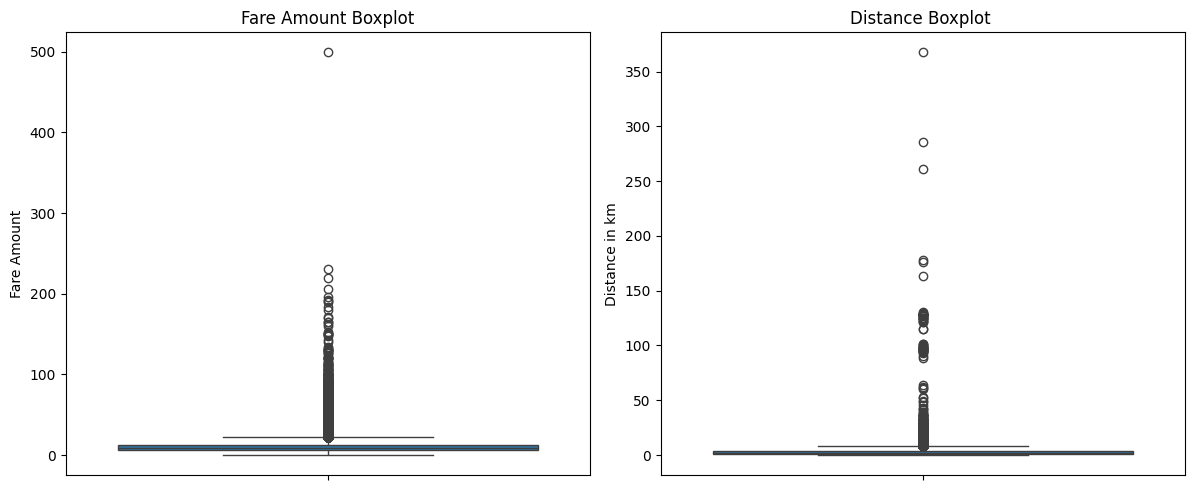

In [ ]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
sns.boxplot(data=uber, y='fare_amount')
plt.title('Fare Amount Boxplot')
plt.ylabel('Fare Amount')

plt.subplot(1,3,2)
sns.boxplot(data=uber, y='distance_km')
plt.title("Distance Boxplot ")
plt.ylabel('Distance in km')
plt.tight_layout()
plt.show()

Now we will detect outliers in uber dataset across fare_amount, passenger_count and Distance_km

We have given logical conditions : such as fare_amount>0 signifies that any ride is valid when the amount is greater than 0.

We get value of lower bound, upper bound and outliers in this column.


In [ ]:
# Detect outliers for fare_amount
fare_lower, fare_upper, fare_outliers = detect_outliers(
    uber, 'fare_amount', 'fare_amount > 0'
)
print(f"Fare Amount Bounds: ({fare_lower}, {fare_upper}), Outliers Detected: {fare_outliers.shape[0]}")

# Detect outliers for manhattan_distance_km
distance_lower, distance_upper, distance_outliers = detect_outliers(
    uber, 'distance_km', 'distance_km > 0'
)
print(f"Distance Bounds: ({distance_lower}, {distance_upper}), Outliers Detected: {distance_outliers.shape[0]}")

# Detect outliers for passenger_count
passenger_lower, passenger_upper, passenger_outliers = detect_outliers(
    uber, 'passenger_count', '(passenger_count > 0) & (passenger_count <= 6)'
)
print(f"Passenger Count Bounds: ({passenger_lower}, {passenger_upper}), Outliers Detected: {passenger_outliers.shape[0]}")

#print(f"All outliers : {fare_outliers.shape} , {distance_outliers.shape}")

Fare Amount Bounds: (-3.75, 22.25), Outliers Detected: 16577
Distance Bounds: (-2.709654466995256, 7.929615169734008), Outliers Detected: 16113
Passenger Count Bounds: (-0.5, 3.5), Outliers Detected: 21863


Observation for outlier boundaries :

 - Fare amount should be max 23.25
 - Distance should be between 0 to 8.04
 - Passenger should be between 1 to 4

To remove non-positive fare amounts values and limits to upper range calculated

same for distance and passenger count

In [ ]:
uber_cleaned = uber[((uber['fare_amount'] > 0) & (uber['fare_amount'] < fare_upper)) &
                            ((uber['distance_km'] < distance_upper) & (uber['distance_km'] > 0)) &
                             ((uber['passenger_count'] > 0) & (uber['passenger_count'] < passenger_upper))]
print(uber_cleaned.shape)
print(uber_cleaned.describe())


(154114, 13)
                                 key    fare_amount  pickup_longitude  \
count                         154114  154114.000000     154114.000000   
mean   2012-03-12 14:04:35.676084480       8.794485        -73.929556   
min    2009-01-01 01:15:22.000000600       0.010000        -75.387785   
25%    2010-08-06 16:28:00.000000512       5.700000        -73.992517   
50%    2012-03-08 23:01:00.000000512       8.000000        -73.982484   
75%    2013-10-11 02:42:00.000000256      11.000000        -73.970408   
max    2015-06-30 23:33:33.000000200      22.200000         40.806012   
std                              NaN       3.962902          2.366255   

       pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  \
count    154114.000000      154114.000000     154114.000000    154114.000000   
mean         40.703799         -73.928040         40.703863         1.266082   
min         -74.009697         -75.375315        -74.015750         1.000000   
25%      

Box plot Without outliers

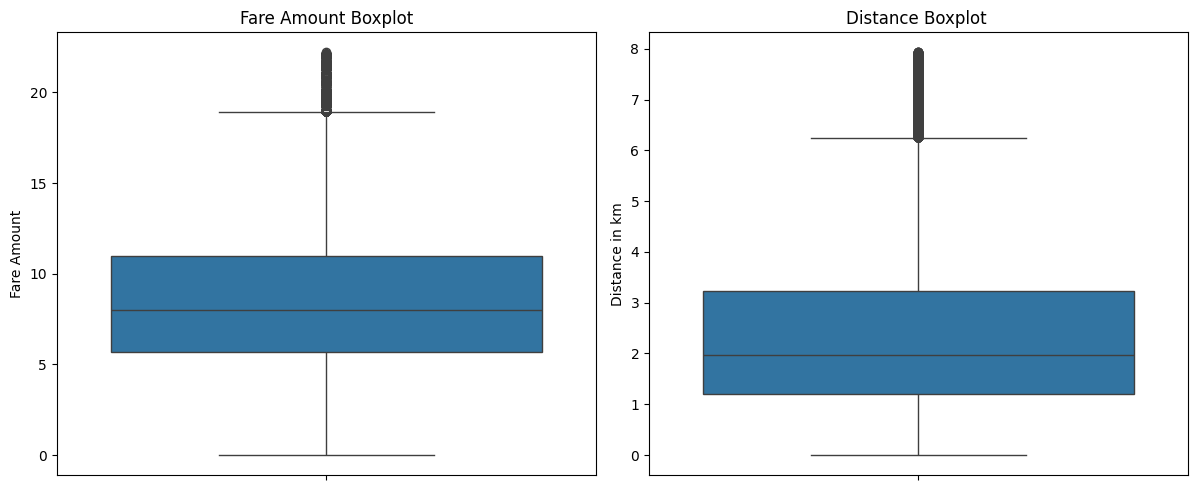

In [ ]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
sns.boxplot(data=uber_cleaned, y='fare_amount')
plt.title('Fare Amount Boxplot')
plt.ylabel('Fare Amount')

plt.subplot(1,3,2)
sns.boxplot(data=uber_cleaned, y='distance_km')
plt.title("Distance Boxplot ")
plt.ylabel('Distance in km')
plt.tight_layout()
plt.show()

Many outliers are removed

In [ ]:
#check correlation

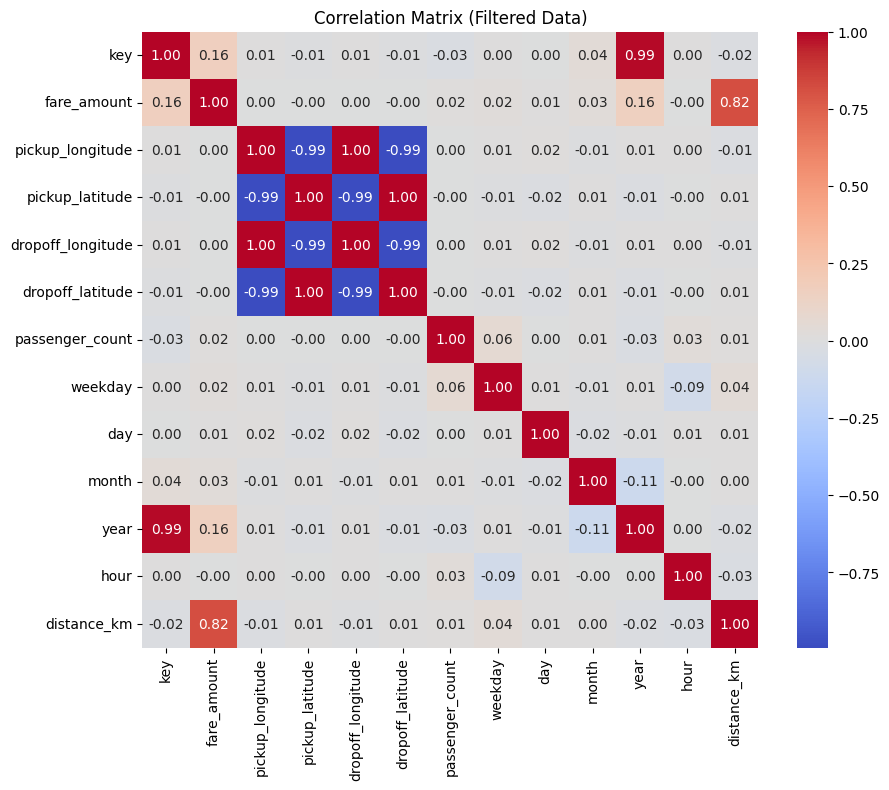

In [ ]:
correlation_matrix_filtered = uber_cleaned.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_filtered, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title('Correlation Matrix (Filtered Data)')
plt.show()

We can observe relation between fare amount and distance : 80%

In [ ]:
#implement linear regression and ridge, lasso regression models

In [ ]:
X = uber_cleaned[['distance_km']]
y = uber_cleaned['fare_amount']

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Create a Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions
y_pred_linear = linear_model.predict(X_test)

# Evaluate the model
linear_rmse = mean_squared_error(y_test, y_pred_linear, squared=False)
linear_r2 = r2_score(y_test, y_pred_linear)

print(f"Linear Regression RMSE: {linear_rmse:.2f}, R^2: {linear_r2:.2f}")

Linear Regression RMSE: 2.28, R^2: 0.67


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [ ]:
# Create a Ridge Regression model with a regularization parameter (alpha)
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

# Make predictions
y_pred_ridge = ridge_model.predict(X_test)

# Evaluate the model
ridge_rmse = mean_squared_error(y_test, y_pred_ridge, squared=False)
ridge_r2 = r2_score(y_test, y_pred_ridge)

print(f"Ridge Regression RMSE: {ridge_rmse:.2f}, R^2: {ridge_r2:.2f}")

Ridge Regression RMSE: 2.28, R^2: 0.67


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [ ]:
# Create a Lasso Regression model with a regularization parameter (alpha)
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

# Make predictions
y_pred_lasso = lasso_model.predict(X_test)

# Evaluate the model
lasso_rmse = mean_squared_error(y_test, y_pred_lasso, squared=False)
lasso_r2 = r2_score(y_test, y_pred_lasso)

print(f"Lasso Regression RMSE: {lasso_rmse:.2f}, R^2: {lasso_r2:.2f}")

Lasso Regression RMSE: 2.28, R^2: 0.67


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [ ]:
# Summary of the results
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression'],
    'RMSE': [linear_rmse, ridge_rmse, lasso_rmse],
    'R^2': [linear_r2, ridge_r2, lasso_r2]
})

print(results)

               Model      RMSE       R^2
0  Linear Regression  2.275336  0.671309
1   Ridge Regression  2.275336  0.671309
2   Lasso Regression  2.275388  0.671294


# Theory

**1. Linear Regression, Ridge, and Lasso**
 - **Linear Regression:**

A fundamental regression technique where the goal is to model the relationship between one or more independent variables (predictors) and a dependent variable (target) by fitting a linear equation.

The model minimizes the sum of squared errors (differences between observed and predicted values).

**Formula :**  y=β0+β1X1+β2X2+...+βnXn+ϵ

**How Linear Regression Works**

Linear regression uses the **Ordinary Least Squares (OLS)** method to estimate the parameters (coefficients) of the model. OLS minimizes the sum of squared residuals, which are the differences between observed values and predicted values.

Residual Sum of Squares = ∑ ( yi - yi' )²


**Assumptions:**

1. Linearity: The relationship between predictors and the target is linear.
2. Independence: Observations are independent of each other.
3. Homoscedasticity: The residuals (errors) have constant variance.
4. Normality: Residuals are normally distributed.

**Evaluating Linear Regression Model Performance**

Common metrics include:

1. Mean Squared Error (MSE): The average squared error.
2. Root Mean Squared Error (RMSE): The square root of MSE, which is in the same units as the target variable.
3. Mean Absolute Error (MAE): The average absolute error, providing a straightforward measure of prediction accuracy.
4. R-squared (R²): Indicates the proportion of variance explained by the model.

**Applications of Linear Regression**
1. Predicting prices (e.g., housing, stocks),
2. Estimating demand (e.g., sales forecasting),
3. Modeling relationships in research (e.g., health, economics).

**Limitations of Linear Regression**
1. Sensitive to outliers.
2. Assumes linearity, which may not always be appropriate.
3. Performs poorly on complex data with many features or nonlinear relationships.



---



- **Ridge Regression (L2 Regularization):**

A variant of linear regression that adds a penalty term to the cost function, proportional to the square of the magnitude of the coefficients.

Helps to handle multicollinearity and prevent overfitting by shrinking the regression coefficients towards zero.

Ridge cost function:
Cost = Sum of Squared Errors +𝜆∑𝛽²i

**Ridge Regression** is an extension of linear regression that adds a regularization (or penalty) term to the loss function. This helps reduce overfitting, particularly when dealing with multicollinearity (high correlation) among predictor variables. Ridge regression is especially useful when you have a large number of predictors, or when the predictors are highly correlated, as it shrinks the coefficients to reduce model complexity.

### 1. **Understanding Ridge Regression**

   - Ridge regression modifies the linear regression cost function by adding a regularization term, which is the sum of squared coefficients. This prevents the model from fitting the noise in the data too closely, which could result in overfitting.
   - **Equation**:
     \[
     \text{Loss Function} = \sum_{i=1}^{n} (Y_i - \hat{Y}_i)^2 + \alpha \sum_{j=1}^{p} \beta_j^2
     \]
     where:
     - \( Y_i \) is the actual value of the dependent variable,
     - \( \hat{Y}_i \) is the predicted value,
     - \( \beta_j \) represents the coefficients of the predictors,
     - \( \alpha \) is the regularization parameter (also called the tuning parameter) that controls the degree of shrinkage applied to the coefficients.

### 2. **Role of the Regularization Parameter \( \alpha \)**

   - \( \alpha \) is a hyperparameter that balances the trade-off between fitting the data well and keeping the coefficients small.
   - **When \( \alpha = 0 \)**: Ridge regression becomes the same as ordinary least squares (OLS) regression, as the regularization term is effectively removed.
   - **When \( \alpha > 0 \)**: Ridge regression begins to shrink the coefficients, reducing their magnitude. As \( \alpha \) increases, the model becomes more regularized, shrinking the coefficients more and simplifying the model.
   - Choosing \( \alpha \) involves a tuning process, often through techniques like cross-validation, to find the optimal value for minimizing error without overfitting or underfitting.

### 3. **How Ridge Regression Reduces Overfitting**

   - By penalizing large coefficients, Ridge regression forces the model to focus on predictors that have a more substantial effect on the target variable, thus preventing it from fitting to the noise in the data.
   - Ridge is less likely to be affected by multicollinearity since it distributes the effect of correlated predictors more evenly by shrinking their coefficients.

### 4. **Example in Comparison to Linear Regression**

   - Suppose you have a model with predictors that are highly correlated with each other. Linear regression could produce large coefficients for each, making the model sensitive to small changes in the data and prone to overfitting.
   - Ridge regression addresses this by shrinking the coefficients, distributing the importance across correlated predictors, and reducing the risk of overfitting.

### 5. **Advantages of Ridge Regression**

   - **Reduced Overfitting**: Helps prevent overfitting by penalizing large coefficients.
   - **Better Performance with Multicollinearity**: Ridge can handle correlated predictors more effectively than ordinary linear regression.
   - **More Stable Predictions**: It often generalizes better on unseen data.

### 6. **Limitations of Ridge Regression**

   - **Does Not Perform Feature Selection**: Ridge regression reduces coefficients but does not eliminate them entirely. Thus, it retains all predictors, unlike Lasso regression, which can set some coefficients to zero and effectively remove predictors.
   - **Depends on Hyperparameter \( \alpha \)**: The model’s effectiveness is highly dependent on choosing the correct \( \alpha \) value.

### 7. **Applications of Ridge Regression**

   - Ridge regression is commonly used in fields where multicollinearity is present and where interpretability is less of a concern, such as:
     - Financial modeling (stock prices, economic indicators),
     - Predictive modeling with high-dimensional data (e.g., genetics, image analysis),
     - Predicting outcomes where predictors are numerous and correlated.

### 8. **Tuning Ridge Regression**

   - **Cross-Validation**: A common approach to finding the optimal \( \alpha \) is by using cross-validation, testing different values of \( \alpha \) and selecting the one that minimizes the prediction error on validation data.
   - **Grid Search**: A systematic way to find the best \( \alpha \) by testing across a range of values.

Ridge regression is a robust technique for regression tasks with multicollinearity and high-dimensional data. By balancing the fit of the model and regularizing coefficient sizes, it often provides more stable and interpretable results compared to ordinary linear regression.



---



- **Lasso Regression (L1 Regularization):**

Similar to Ridge, but adds an L1 penalty, which is the sum of the absolute values of the coefficients.

Lasso not only reduces overfitting but can also reduce some coefficients to zero, effectively performing feature selection.

Lasso cost function:
Cost = Sum of Squared Errors + 𝜆 * ∑ ∣𝛽𝑖∣

**Lasso Regression** (Least Absolute Shrinkage and Selection Operator) is a type of linear regression that adds an L1 regularization term to the cost function. Like Ridge regression, it helps to prevent overfitting by penalizing large coefficients, but unlike Ridge, it can also perform feature selection by driving some coefficients to zero, effectively removing unimportant predictors from the model. This makes it especially useful when dealing with high-dimensional data and situations where only a subset of predictors is relevant.

### 1. **Understanding Lasso Regression**

   - Lasso regression modifies the linear regression cost function by adding a penalty that is the sum of the absolute values of the coefficients (L1 regularization).
   - **Equation**:
     \[
     \text{Loss Function} = \sum_{i=1}^{n} (Y_i - \hat{Y}_i)^2 + \alpha \sum_{j=1}^{p} |\beta_j|
     \]
     where:
     - \( Y_i \) is the actual value of the dependent variable,
     - \( \hat{Y}_i \) is the predicted value,
     - \( \beta_j \) represents the coefficients of the predictors,
     - \( \alpha \) is the regularization parameter that controls the degree of shrinkage.

### 2. **Role of the Regularization Parameter \( \alpha \)**

   - The \( \alpha \) parameter controls the strength of the penalty:
     - **When \( \alpha = 0 \)**: Lasso regression is equivalent to ordinary least squares (OLS) regression since the penalty term is removed.
     - **As \( \alpha \) increases**: The penalty increases, causing the coefficients to shrink, with some being driven to zero if they are not important.
   - By tuning \( \alpha \), Lasso can exclude features, simplifying the model and improving interpretability.

### 3. **How Lasso Regression Reduces Overfitting and Selects Features**

   - **Feature Selection**: Unlike Ridge regression, which only reduces the magnitude of coefficients, Lasso can drive some coefficients to zero. This process effectively removes predictors that have minimal impact on the target variable, performing automatic feature selection.
   - **Reduces Model Complexity**: By shrinking irrelevant coefficients to zero, Lasso creates a simpler, more interpretable model that generalizes better to new data.

### 4. **Example in Comparison to Ridge Regression**

   - Suppose a model includes many features, but only a few are truly influential. While Ridge would reduce the magnitude of all coefficients, Lasso would set some coefficients to zero, selecting only the most important predictors.
   - If you had predictors that were noisy or redundant, Lasso would effectively eliminate them, making the model easier to interpret and likely improving its performance on unseen data.

### 5. **Advantages of Lasso Regression**

   - **Performs Feature Selection**: By setting some coefficients to zero, Lasso simplifies the model by excluding irrelevant predictors, which is particularly useful for high-dimensional datasets.
   - **Reduces Overfitting**: Like Ridge regression, Lasso also penalizes large coefficients, reducing the model's likelihood of overfitting the data.
   - **Improves Interpretability**: By retaining only important predictors, Lasso makes the model easier to interpret, especially in applications where sparsity is desirable.

### 6. **Limitations of Lasso Regression**

   - **Can Be Biased for Highly Correlated Predictors**: When predictors are highly correlated, Lasso tends to select only one of them while shrinking others to zero, which might not be ideal in every situation.
   - **Struggles with Multicollinearity**: In cases of multicollinearity (high correlation among predictors), Ridge regression might perform better since it doesn’t eliminate features but rather shrinks them.
   - **Tuning \( \alpha \) is Crucial**: The model's performance highly depends on finding an optimal \( \alpha \), which can vary for different datasets.

### 7. **Applications of Lasso Regression**

   - **Feature Selection in High-Dimensional Data**: Lasso is particularly useful in fields where data has many predictors but only a subset significantly affects the target, such as genomics, image processing, or natural language processing.
   - **Models Where Interpretability is Key**: It is applied when selecting a small number of predictors is preferable for interpretability or cost reasons, as in marketing or financial modeling.

### 8. **Tuning Lasso Regression**

   - **Cross-Validation**: Often used to find the best value of \( \alpha \), cross-validation involves testing different values on subsets of the data to identify the optimal one that minimizes prediction error.
   - **Grid Search or Randomized Search**: These techniques systematically search a range of \( \alpha \) values to find the optimal setting.

### 9. **Comparison with Other Regularization Techniques**

   - **Ridge vs. Lasso**: While Ridge regression only reduces the size of coefficients, Lasso can eliminate them entirely, making it effective for feature selection. Ridge is typically preferred when all predictors contribute meaningfully to the model.
   - **Elastic Net**: A combination of Ridge and Lasso, Elastic Net applies both L1 and L2 penalties, balancing the strengths of both. It’s particularly useful when predictors are highly correlated.

Lasso regression is a valuable tool for both reducing overfitting and performing feature selection. It simplifies the model by removing irrelevant predictors, improving generalization on new data, especially in high-dimensional datasets where only a subset of features is important.

**Other Regression Models :**
- Polynomial regression
- Elastic net regression
- Decision Tree Regressor
- Random Forest Regressor
- Support Vector Regression
- K-Nearest Neighbors Regression

**Evaluation Metrics**

**Mean Squared Error (MSE):**

Measures the average of the squared differences between predicted and actual values.

**Formula:** MSE= 1/n ∑ ( yi - yi' )²

Lower values indicate better model performance.

**Interpretation:**  MSE quantifies how far off predictions are from actual values, giving greater weight to larger errors due to the squaring of differences.
 - Lower MSE: Indicates better fit, as it implies smaller errors in prediction.
 - Higher MSE: Indicates poorer fit, suggesting that predictions are far from actual values on average.

**Usefulness:** MSE is useful for directly measuring the error of the model in the same units as the square of the target variable. It is sensitive to outliers (since it squares errors), making it beneficial for detecting significant deviations.

**Conclusion:** MSE provides a measure of the average error magnitude, where smaller values are better.

---


**R-Squared (R² Score):**

Indicates the proportion of variance in the dependent variable that is predictable from the independent variables.

Ranges from 0 to 1 (or negative for poor fits); closer to 1 indicates a better fit.

**Formula**:
R² = 1 - SS(res)/SS(tot)

where SS(res) is the sum of squared residuals (errors), and SS(tot) is the total sum of squares (variance of the target values around their mean).

**Interpretation:**  R² is a measure of how well the model explains the variability of the target variable.

 - R² = 1: Perfect fit, indicating that all the variability of the target is captured by the model.
 - R² = 0: The model does no better than simply using the mean of the target values.
 - Negative R²: This can occur if the model fits the data poorly, performing worse than a horizontal line through the mean of the target values.

**Usefulness:** R² provides an easily interpretable score, showing how well the independent variables collectively explain the target’s variance. However, a high R² doesn’t always mean a model is good, as it can be inflated with more predictors (overfitting). In such cases, Adjusted R² can provide a more accurate measure by adjusting for the number of predictors.

**Conclusion :**
R² Score tells how well the model captures the variability in the target, with values closer to 1 indicating a better fit.


**Other Evaluation metrics**

- **Root Mean Squared Error (RMSE):**

Square root of MSE; gives an error measure in the same units as the target variable.

Useful for interpreting the model’s performance in the target's scale.

Formula:
RMSE = ²_/(MSE)  or (MSE)^0.5

- **Mean Absolute Error (MAE):**

Average of absolute differences between actual and predicted values.

Less sensitive to large errors than MSE.

Formula:
MAE = 1 / n ( ∑ | yi - yi' | )

- **Adjusted R-Squared:**
Adjusted for the number of predictors, giving a more accurate measure for multiple regression models.

Penalizes for adding variables that do not improve the model.
